# Logistic Regression with Macro Data

In [1]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('whitegrid')

## Data Set

| Variable   | Description                                  | Transformation     |
|------------|----------------------------------------------|--------------------|
| realgdp    | Real gross domestic product                  | Annual Growth Rate |
| realcons   | Real personal consumption expenditures       | Annual Growth Rate |
| realinv    | Real gross private domestic investment       | Annual Growth Rate |
| realgovt   | Real federal expenditures & gross investment | Annual Growth Rate |
| realdpi    | Real private disposable income               | Annual Growth Rate |
| m1         | M1 nominal money stock                       | Annual Growth Rate |
| tbilrate   | Monthly treasury bill rate                 | Level              |
| unemp      | Seasonally adjusted unemployment rate (%)    | Level              |
| infl       | Inflation rate                               | Level              |
| realint    |  Real interest rate                          | Level              |

In [3]:
data = pd.DataFrame(sm.datasets.macrodata.load().data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   year      203 non-null    float64
 1   quarter   203 non-null    float64
 2   realgdp   203 non-null    float64
 3   realcons  203 non-null    float64
 4   realinv   203 non-null    float64
 5   realgovt  203 non-null    float64
 6   realdpi   203 non-null    float64
 7   cpi       203 non-null    float64
 8   m1        203 non-null    float64
 9   tbilrate  203 non-null    float64
 10  unemp     203 non-null    float64
 11  pop       203 non-null    float64
 12  infl      203 non-null    float64
 13  realint   203 non-null    float64
dtypes: float64(14)
memory usage: 22.3 KB


In [4]:
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


## Data Prep

To obtain a binary target variable, we compute the 20-quarter rolling average of the annual growth rate of quarterly real GDP. We then assign 1 if current growth exceeds the moving average and 0 otherwise. Finally, we shift the indicator variables to align next quarter's outcome with the current quarter.

In [5]:
data['growth_rate'] = data.realgdp.pct_change(4)
data['target'] = (data.growth_rate > data.growth_rate.rolling(20).mean()).astype(int).shift(-1)
data.quarter = data.quarter.astype(int)

In [6]:
data.target.value_counts()

0.0    112
1.0     90
Name: target, dtype: int64

In [7]:
data.tail()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,growth_rate,target
198,2008.0,3,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33,0.000262,0.0
199,2008.0,4,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91,-0.018619,0.0
200,2009.0,1,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71,-0.033026,0.0
201,2009.0,2,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19,-0.038297,0.0
202,2009.0,3,12990.341,9256.0,1486.398,1044.088,10040.6,216.385,1673.9,0.12,9.6,308.013,3.56,-3.44,-0.025086,NaN


In [8]:
pct_cols = ['realcons', 'realinv', 'realgovt', 'realdpi', 'm1']
drop_cols = ['year', 'realgdp', 'pop', 'cpi', 'growth_rate']
data.loc[:, pct_cols] = data.loc[:, pct_cols].pct_change(4)

In [9]:
data = pd.get_dummies(data.drop(drop_cols, axis=1), columns=['quarter'], drop_first=True).dropna()

In [10]:
data.head()

,realcons,realinv,realgovt,realdpi,m1,tbilrate,unemp,infl,realint,target,quarter_2,quarter_3,quarter_4
4,0.036957,0.156237,-0.016692,0.036356,-0.000716,3.50,5.2,2.31,1.19,0.0,0,0,0
5,0.034147,-0.040877,-0.043426,0.024170,-0.010586,2.68,5.2,0.14,2.55,0.0,1,0,0
6,0.019409,0.024718,-0.033758,0.026821,0.002847,2.36,5.6,2.70,-0.34,0.0,0,1,0
7,0.019673,-0.132257,-0.015738,0.018278,0.007857,2.29,6.3,1.21,1.08,0.0,0,0,1
8,0.009715,-0.196903,0.029544,0.014830,0.017908,2.37,6.8,-0.40,2.77,0.0,0,0,0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 198 entries, 4 to 201
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   realcons   198 non-null    float64
 1   realinv    198 non-null    float64
 2   realgovt   198 non-null    float64
 3   realdpi    198 non-null    float64
 4   m1         198 non-null    float64
 5   tbilrate   198 non-null    float64
 6   unemp      198 non-null    float64
 7   infl       198 non-null    float64
 8   realint    198 non-null    float64
 9   target     198 non-null    float64
 10  quarter_2  198 non-null    uint8  
 11  quarter_3  198 non-null    uint8  
 12  quarter_4  198 non-null    uint8  
dtypes: float64(10), uint8(3)
memory usage: 17.6 KB


We use an intercept and convert the quarter values to dummy variables and train the logistic regression model as follows:

This produces the following summary for our model with 198 observations and 13 variables, including intercept:
The summary indicates that the model has been trained using maximum likelihood and provides the maximized value of the log-likelihood function at -67.9.

In [12]:
model = sm.Logit(data.target, sm.add_constant(data.drop('target', axis=1)))
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.342965
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                  198
Model:                          Logit   Df Residuals:                      185
Method:                           MLE   Df Model:                           12
Date:                Wed, 15 Feb 2023   Pseudo R-squ.:                  0.5022
Time:                        17:16:10   Log-Likelihood:                -67.907
converged:                       True   LL-Null:                       -136.42
Covariance Type:            nonrobust   LLR p-value:                 2.375e-23
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.5881      1.908     -4.502      0.000     -12.327      -4.849
realcons     130.1446     26.633      4.887      0.000      77.945     182.344
realinv       18.8414      4.053      4.648      0.000      10.897      26.786
realgovt     -19.0318      6.010     -3.166      0.002     -30.812      -7.252
realdpi      -52.2473     19.912     -2.624      0.009     -91.275     -13.220
m1            -1.3462      6.177     -0.218      0.827     -13.453      10.761
tbilrate      60.8607     44.350      1.372      0.170     -26.063     147.784
unemp          0.9487      0.249      3.818      0.000       0.462       1.436
infl         -60.9647     44.362     -1.374      0.169    -147.913      25.984
realint      -61.0453     44.359     -1.376      0.169    -147.987      25.896
quarter_2      0.1128      0.618      0.182      0.855      -1.099       1.325
quarter_3     -0.1991      0.609     -0.327      0.744      -1.393       0.995
quarter_4      0.0007      0.608      0.001      0.999      -1.191       1.192
==============================================================================
"""

The LL-Null value of -136.42 is the result of the maximized log-likelihood function when only an intercept is included. It forms the basis for the pseudo-R2 statistic and the Log-Likelihood Ratio (LLR) test. 
The pseudo-R2 statistic is a substitute for the familiar R2 available under least squares. It is computed based on the ratio of the maximized log-likelihood function for the null model m0 and the full model m1 as follows:
The values vary from 0 (when the model does not improve the likelihood) to 1 where the model fits perfectly and the log-likelihood is maximized at 0. Consequently, higher values indicate a better fit.


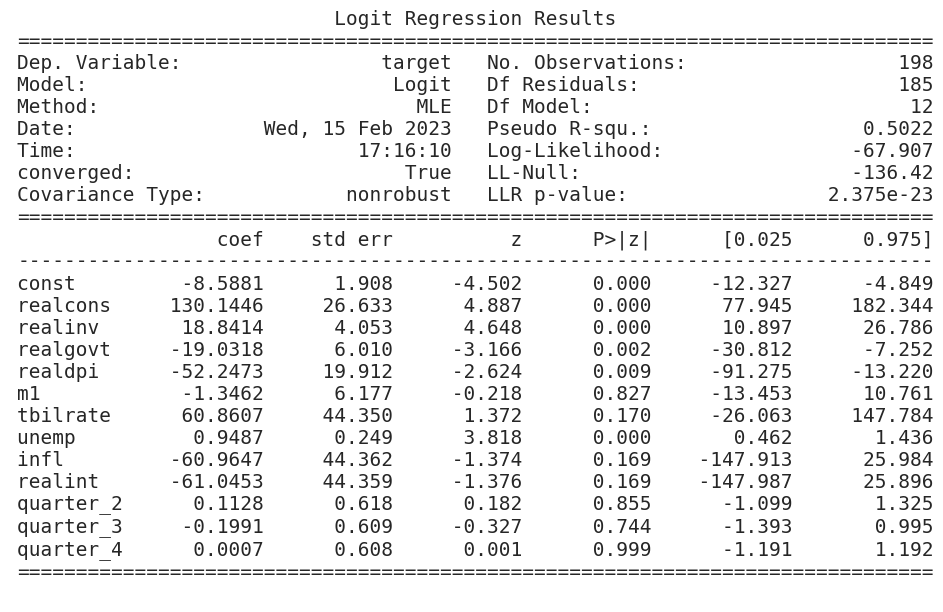

In [13]:
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(result.summary()), {'fontsize': 14}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.1)
plt.savefig('logistic_example.png', bbox_inches='tight', dpi=300);